<a href="https://colab.research.google.com/github/gitBokyung/credit_card_delinquency/blob/master/credit_card_delinquency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 신용카드 사용자 연체 예측 프로젝트

#### 1. 개요
: 본 프로젝트는 사용자의 신용등급을 예측하는 문제입니다. 다양한 피처들의 데이터분석, 전처리, 피처 엔지니어링, 모델링 기법을 활용하여 예측 분석 알고리즘 개발

#### 2. 목적
- 성별, 소득, 직업 등의 피처를 분석하여 사용자의 신용등급을 예측
- 금융기관은 이러한 예측을 통해 대출, 신용카드 발급, 기타 금융서비스 제공 시 리스크 최소화 가능
- 개인화된 금융 상품과 서비스 제공 가능


---

# 1. 데이터 확인

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

#압축 풀기
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/데이콘/1. 신용카드 연체 예측/data/card.zip' -d './dataset'

In [ ]:
train_url = '/content/dataset/open/train.csv'
train = pd.read_csv(train_url, index_col=0)

test_url = '/content/dataset/open/test.csv'
test = pd.read_csv(test_url, index_col=0)

train.info()
# occyp_type : 직업유형에 결측치 존재

<class 'pandas.core.frame.DataFrame'>
Index: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit     

In [ ]:
train.describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [ ]:
# Target 변수의 class별 비율 확인
# 클래스 불균형 여부 확인
target_counts = train['credit'].value_counts()
target_ratio = train['credit'].value_counts(normalize=True)

display(target_counts)
display(target_ratio)
# 데이터 불균형하므로 이를 해결하고, 모델링 적용 유의

,count
credit,
2.0,16968
1.0,6267
0.0,3222


,proportion
credit,
2.0,0.641343
1.0,0.236875
0.0,0.121783


# 2. 연속형 변수 EDA
- 연속형 피쳐별 데이터 분포 확인 및 전처리

In [ ]:
%matplotlib inline

import seaborn as sns
import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리


!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

In [ ]:
import warnings

warnings.filterwarnings("ignore")

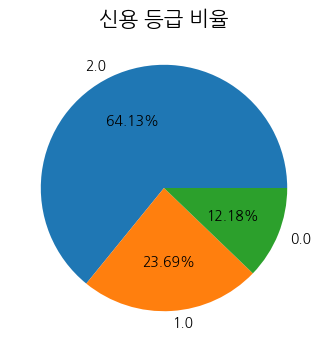

In [ ]:
fig,ax = plt.subplots(figsize = (4,4))

credit_freq = train['credit'].value_counts()

ax.pie(credit_freq, labels = credit_freq.index, autopct="%.2f%%")
plt.title('신용 등급 비율', size=15)
plt.show()

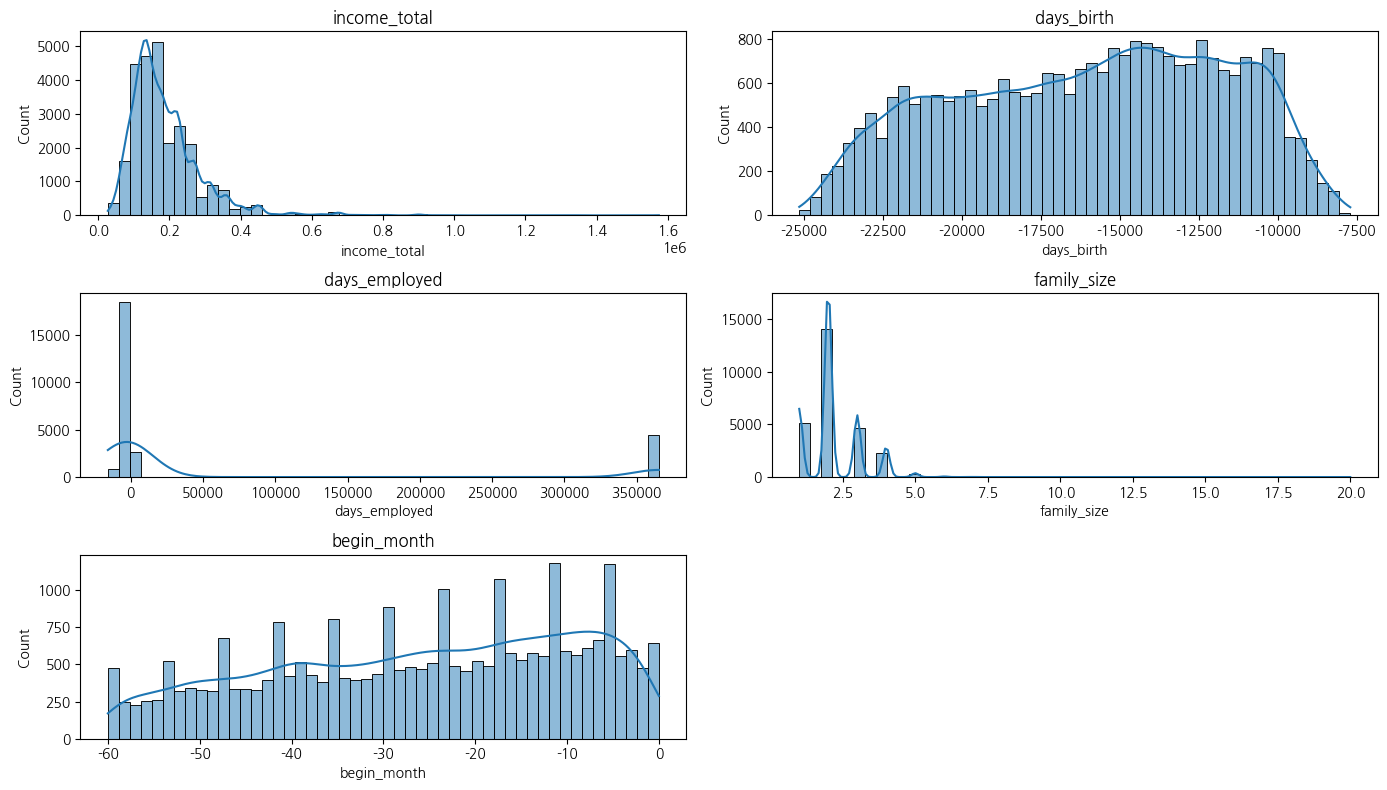

In [ ]:
# 연속형 변수 히스토그램으로 확인
train.rename(columns={'DAYS_BIRTH' : 'days_birth',
                      'DAYS_EMPLOYED' : 'days_employed'}, inplace=True)

sequential_columns = ['income_total','days_birth', 'days_employed', 'family_size','begin_month']

fig,ax = plt.subplots(3,2, figsize=(14,8))

for idx, col in enumerate(sequential_columns):
  r, c = divmod(idx,2)
  sns.histplot(train[col], bins=50, kde=True, ax=ax[r][c])
  ax[r][c].set_title(col)

# 빈 subplot은 제거
fig.delaxes(ax[2][1])

plt.tight_layout()
plt.show()


- ['income_total','days_employed','family_size'] 피쳐에 이상치 존재 확인
- 이상치 및 정규화 처리 필요

family_size의 값이 6이상인 데이터의 비율은 0.0 %입니다.


family_size,1.0,2.0,3.0,4.0,5.0,6.0,7.0,9.0,15.0,20.0
credit,,,,,,,,,,
0.0,605.0,1720.0,610.0,251.0,27.0,7.0,2.0,NaN,NaN,NaN
1.0,1318.0,3249.0,1088.0,520.0,74.0,12.0,6.0,NaN,NaN,NaN
2.0,3186.0,9137.0,2934.0,1489.0,190.0,25.0,1.0,2.0,3.0,1.0


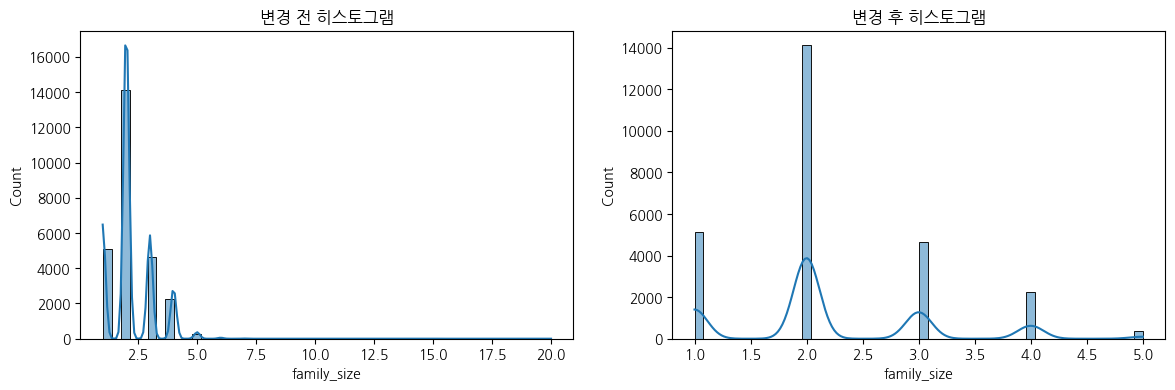

In [ ]:
# 변경 전 시각화
fig,ax = plt.subplots(1,2,figsize=(14,4))
sns.histplot(train['family_size'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('변경 전 히스토그램')

# family_size 피쳐 조정
# 6이상은 5로 값 조정
train['family_size'].value_counts()

# 1. family_size 값이 6이상인 데이터의 비율
print('family_size의 값이 6이상인 데이터의 비율은',\
      round(len(train[train['family_size'] >= 6]) / len(train),2), '%입니다.' )

# 2. credit과 family_size 관계 확인
display(train.groupby(['credit','family_size'])['family_size'].count().unstack())

# 3. family_size 6이상인 값은 5로 합치기
train['family_size'] = train['family_size'].apply(lambda x: 5 if x>=6 else x)
test['family_size'] = test['family_size'].apply(lambda x: 5 if x>=6 else x)

# 4. 합친 후의 family_size 분포 시각화
sns.histplot(train['family_size'], bins=50, kde=True, ax=ax[1])
ax[1].set_title('변경 후 히스토그램')
plt.show()

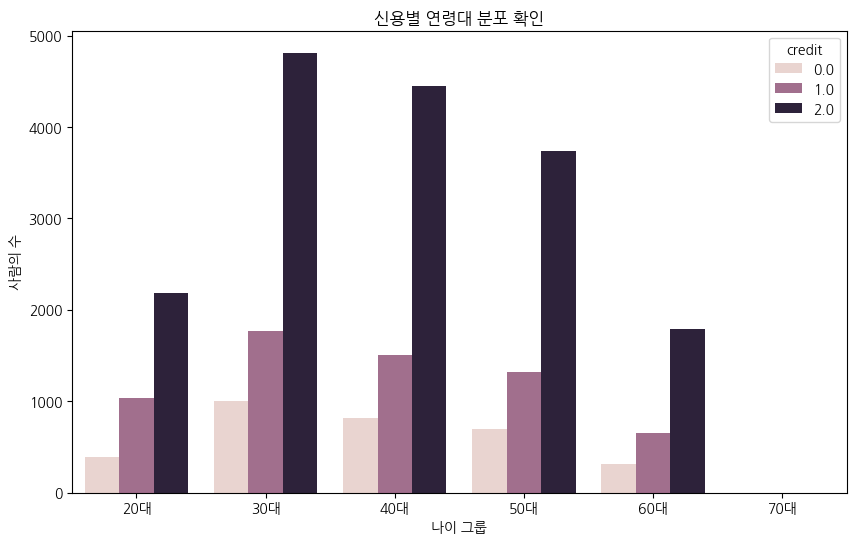

In [ ]:
train.rename(columns={'DAYS_BIRTH': 'days_birth', 'DAYS_EMPLOYED': 'days_employed', 'occyp_type':'job_type'}, inplace=True)
test.rename(columns={'DAYS_BIRTH': 'days_birth', 'DAYS_EMPLOYED': 'days_employed', 'occyp_type':'job_type'}, inplace=True)
# 신용 등급별 연령대 분포 시각화
# 나이 계산
train['age'] = train['days_birth'] // -365
test['age'] = test['days_birth'] // -365

# 연령대 구분
bins = [20,30,40,50,60,70,80]
labels = ['20대','30대','40대','50대','60대','70대']

# pd.cut() 으로 나이대 구분
train['age_group'] = pd.cut(train['age'], bins=bins, labels=labels, right=False)
test['age_group'] = pd.cut(test['age'], bins=bins, labels=labels, right=False)

# 연령대별 인원수 시각화
plt.figure(figsize=(10,6))
sns.countplot(x='age_group', data=train, order=labels, hue='credit')
plt.title('신용별 연령대 분포 확인')
plt.ylabel('사람의 수')
plt.xlabel('나이 그룹')
plt.show()

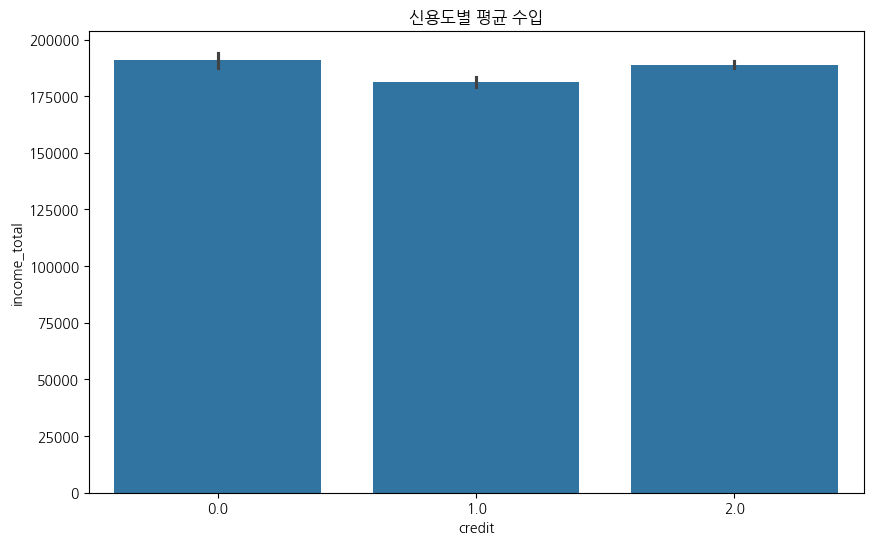

In [ ]:
# 신용도별로 평균 소득 시각화
# 신용도와 소득 간에 유의미한 관계가 있는지 확인
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x=train['credit'], y=train['income_total'], ax=ax)
ax.set_title('신용도별 평균 수입')
plt.show()

- 신용등급이 높을수록 평균 소득이 높은 것이 절대적인 것은 아니다.
- 소득만이 신용도를 결정하는 유일한 요인이 아님
- 소득 외에도 신용 위험을 평가하는 데 중요한 다른 요소가 있을 수 있음.

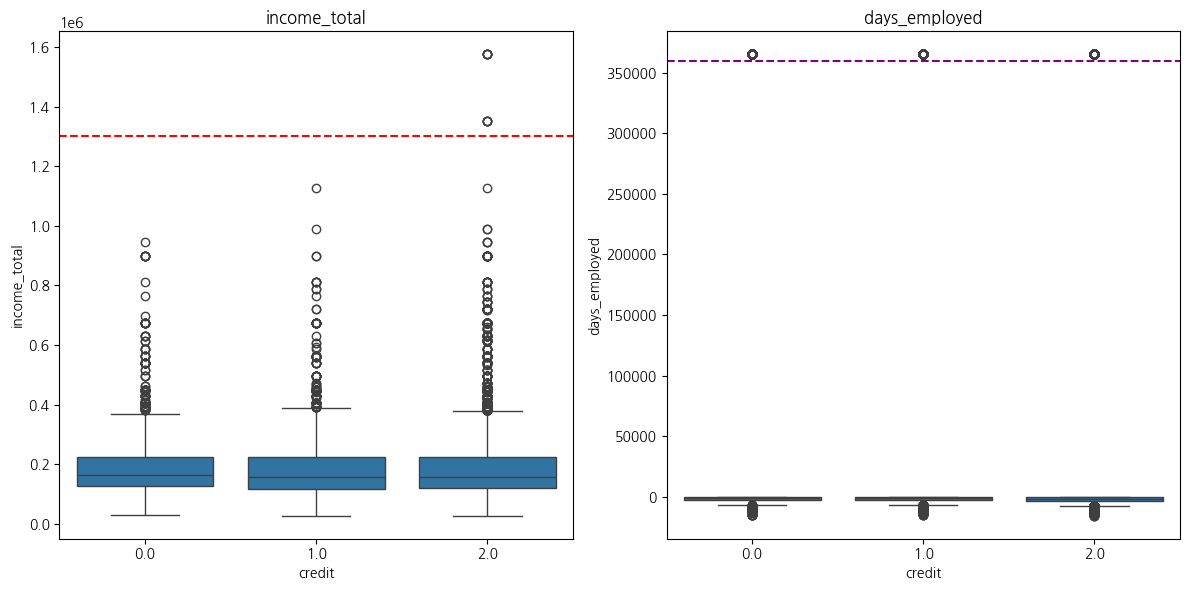

income_total 칼럼에서 극단치의 값은 9개 입니다.
days_employed 칼럼에서 극단치의 값은 4438개 입니다.


In [ ]:
# 박스플롯을 활용한 이상치 탐지
# 이전에 income_total 과 days_employed 피쳐에 이상치가 높았음
import numpy as np

outlier_cols = ['income_total', 'days_employed']

fig,ax = plt.subplots(1,2,figsize=(12,6))

for idx,col in enumerate(outlier_cols):
  sns.boxplot(x='credit',y=col,data=train,ax=ax[idx])
  ax[idx].set_title(col)

# 이상치로 규정할 수치
ax[0].axhline(y=1.3e6,color='red',linestyle='--')
ax[1].axhline(y=360000,color='purple',linestyle='--')

plt.tight_layout()
plt.show()

# 컬럼별 극단치 갯수 확인
income_outliers = train[ (train['credit'] == 2.0) & (train['income_total'] >= 1.3e6)]
days_employed_outliers = train[train['days_employed']>=360000]

len_income_outliers = len(income_outliers)
len_days_employed_outliers = len(days_employed_outliers)

print(f'income_total 칼럼에서 극단치의 값은 {len_income_outliers}개 입니다.')
print(f'days_employed 칼럼에서 극단치의 값은 {len_days_employed_outliers}개 입니다.')

# income_total 에서 매우 큰 극단치는 제거하고 -> Boxcox로 정규화 & 표준화 스케일링
# days_employed 에서 매우 큰 극단치는 다른 값으로 대체

In [ ]:
# days_employed 피처의 극단값 데이터 EDA
outlier_employed_train = train[train['days_employed'] >= 360000]
display(outlier_employed_train)

print(outlier_employed_train['job_type'].value_counts())

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,days_birth,...,FLAG_MOBIL,work_phone,phone,email,job_type,family_size,begin_month,credit,age,age_group
index,,,,,,,,,,,,,,,,,,,,,
14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,...,1,0,1,0,NaN,1.0,-41.0,2.0,62,60대
18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,...,1,0,0,0,NaN,2.0,-37.0,2.0,63,60대
21,F,N,N,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21253,...,1,0,1,0,NaN,2.0,-7.0,2.0,58,50대
24,F,N,N,0,202500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22361,...,1,0,1,0,NaN,1.0,-5.0,2.0,61,60대
46,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21100,...,1,0,1,0,NaN,1.0,-24.0,2.0,57,50대
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26431,F,N,Y,0,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21151,...,1,0,0,1,NaN,1.0,-60.0,1.0,57,50대
26432,F,Y,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22314,...,1,0,1,0,NaN,2.0,-17.0,1.0,61,60대
26439,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-19238,...,1,0,0,0,NaN,2.0,-57.0,2.0,52,50대


Series([], Name: count, dtype: int64)


# 3. 범주형 변수 EDA 및 결측값 정제

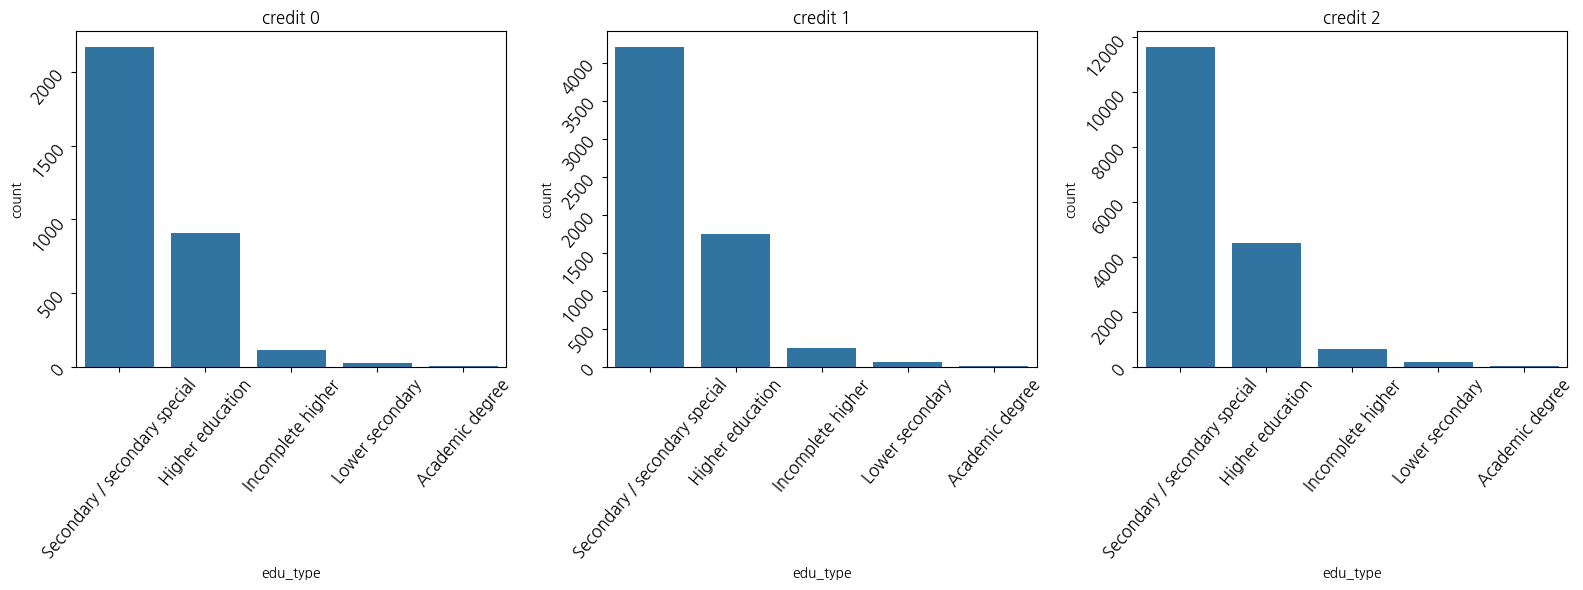

In [ ]:
# 신용등급 클래스별 데이터 필터링
train_0 = train[train['credit'] == 0]
train_1 = train[train['credit'] == 1]
train_2 = train[train['credit'] == 2]

# 각 credit별 데이터프레임 리스트 객체 생성
train_dfs = [train_0, train_1, train_2]
title = ['credit 0','credit 1', 'credit 2']

# credit별로 범주형 변수 분포 확인
def category_countplot(column):
  fig,ax = plt.subplots(1,3,figsize=(16,6))

  for i in range(len(title)):
    sns.countplot(x=column, data=train_dfs[i], ax=ax[i], order=train_dfs[i][column].value_counts().index)
    ax[i].tick_params(labelsize=12, rotation=50)
    ax[i].set_title(title[i])
    ax[i].set_ylabel('count')

  plt.tight_layout()
  plt.show()

  return ax

# credit 클래스별 유의미한 범주형 변수가 있는지 확인
col_names = [ 'gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'flag_mobil', 'work_phone', 'phone', 'email']
result_countplot = category_countplot(col_names[4])

- income_type : credit 1,2번에 0번에는 없는 요소가 있음 (student)

In [ ]:
# income_type 및 edu_type 빈도가 낮은 카테고리에 대한 EDA
income_type_counts = train['income_type'].value_counts()
edu_type_counts = train['edu_type'].value_counts()

# 빈도가 낮은 카테고리
last_income_type = income_type_counts.index[-1]
last_edu_type = edu_type_counts.index[-1]

# 빈도가 낮은 카테고리에 대한 income_total 평균 및 중앙값 계산
last_income_type_mean = train[train['income_type'] == last_income_type]['income_total'].mean()
last_income_type_median = train[train['income_type'] == last_income_type]['income_total'].median()

last_edu_type_mean = train[train['edu_type'] == last_edu_type]['income_total'].mean()
last_edu_type_median = train[train['edu_type'] == last_edu_type]['income_total'].median()

print(f"income_total의 평균은 {round((train['income_total'].mean()),2)}, 중앙값은 {round((train['income_total'].median()),2)}입니다.")
print('-'*60)
print(f'{last_income_type}의 income_total 평균값은 {last_income_type_mean}, income_total 중앙값은 {last_income_type_median}입니다.')
print(f'{last_edu_type}의 income_total 평균값은 {last_edu_type_mean}, income_total 중앙값은 {last_edu_type_median}입니다.')

income_total의 평균은 187306.52, 중앙값은 157500.0입니다.
------------------------------------------------------------
Student의 income_total 평균값은 149142.85714285713, income_total 중앙값은 171000.0입니다.
Academic degree의 income_total 평균값은 241630.4347826087, income_total 중앙값은 270000.0입니다.


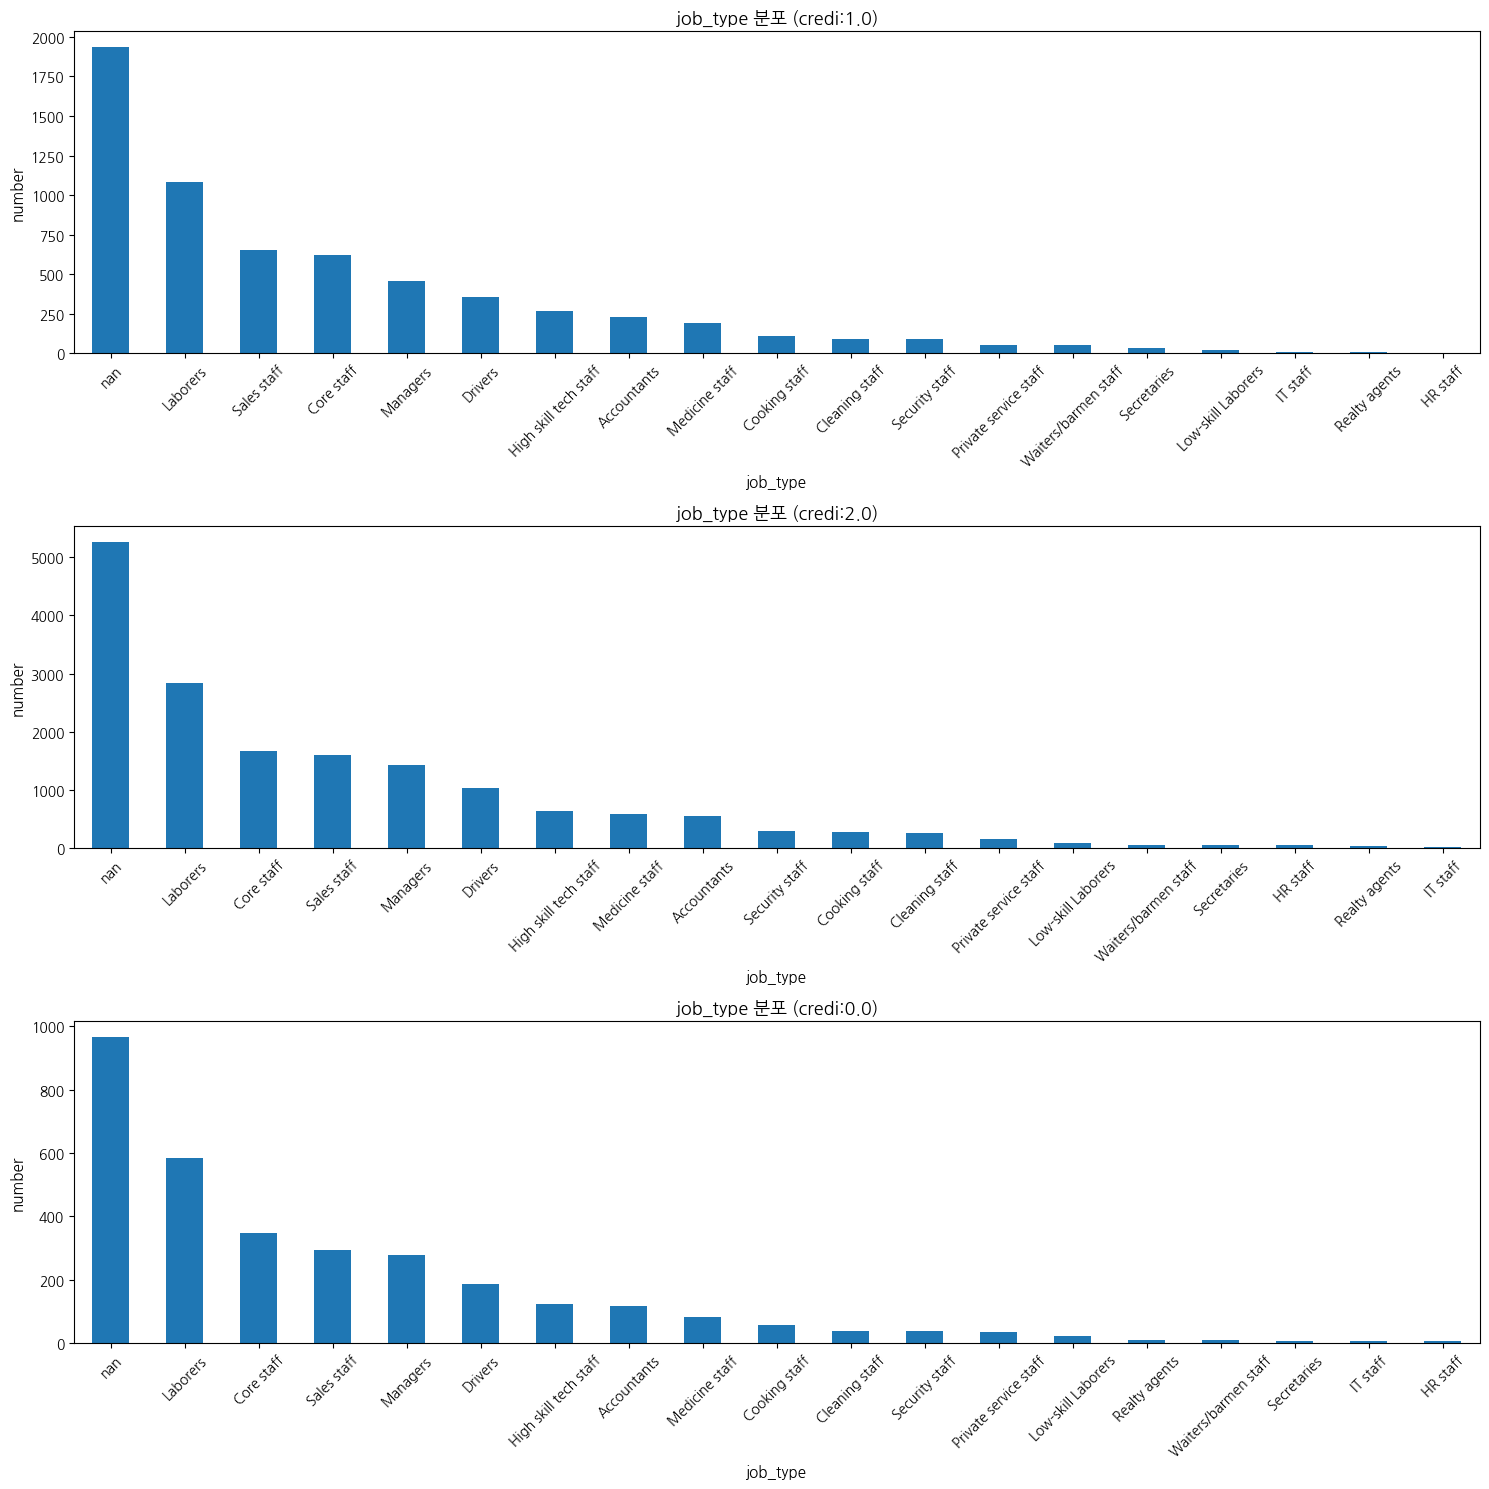

In [ ]:
# job_type 칼럼의 결측값을 문자열 nan으로 채움
train['job_type'] = train['job_type'].fillna('nan')
test['job_type'] = test['job_type'].fillna('nan')

# 데이터셋 내에서 어떤 고유한 신용 등급들이 있는지 확인
credits = train['credit'].unique()

# 각 credit 값별로 job_type의 분포를 시각화
fig,axes = plt.subplots(len(credits), 1, figsize=(15, 5*len(credits)))

for i, credit in enumerate(credits):
    job_type_credit = train[train['credit'] == credit]['job_type'].value_counts()
    job_type_credit.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'job_type 분포 (credi:{credit})', fontsize=13)
    axes[i].set_xlabel('job_type',fontsize=11)
    axes[i].set_ylabel('number',fontsize=11)
    axes[i].set_xticklabels(labels=job_type_credit.index, rotation=45)

plt.tight_layout();
plt.show()

- credit 클래스별로 NaN 결측값이 매우 많음
- 소득유형, 교육수준 등에 따라 결측값을 가진 직업 유형을 적절한 값으로 대체할 필요가 있음

In [ ]:
# job_type 결측값 및 income_type에 따른 분포 분석
print('job_type이 nan인 income_type 빈도 확인')
print(train[train['job_type']=='nan']['income_type'].value_counts())

print('-'*40)

# job_type 에서 등장빈도가 낮은 고유값 확인 (하위 3개)
low_freq_sum = train['job_type'].value_counts()[-3:].sum()
print(f'하위 3 개의 고유값의 등장빈도는 전체 데이터의 {low_freq_sum / len(train) * 100}% 입니다.')

job_type이 nan인 income_type 빈도 확인
income_type
Pensioner               4440
Working                 2312
Commercial associate    1026
State servant            392
Student                    1
Name: count, dtype: int64
----------------------------------------
하위 3 개의 고유값의 등장빈도는 전체 데이터의 0.6274331934837661% 입니다.


- job_type 결측값 중 상당 부분은 연금 수령자로 분류됨 -> 일을 하지 않기 때문에 '무직'으로 분류 할 수 있음

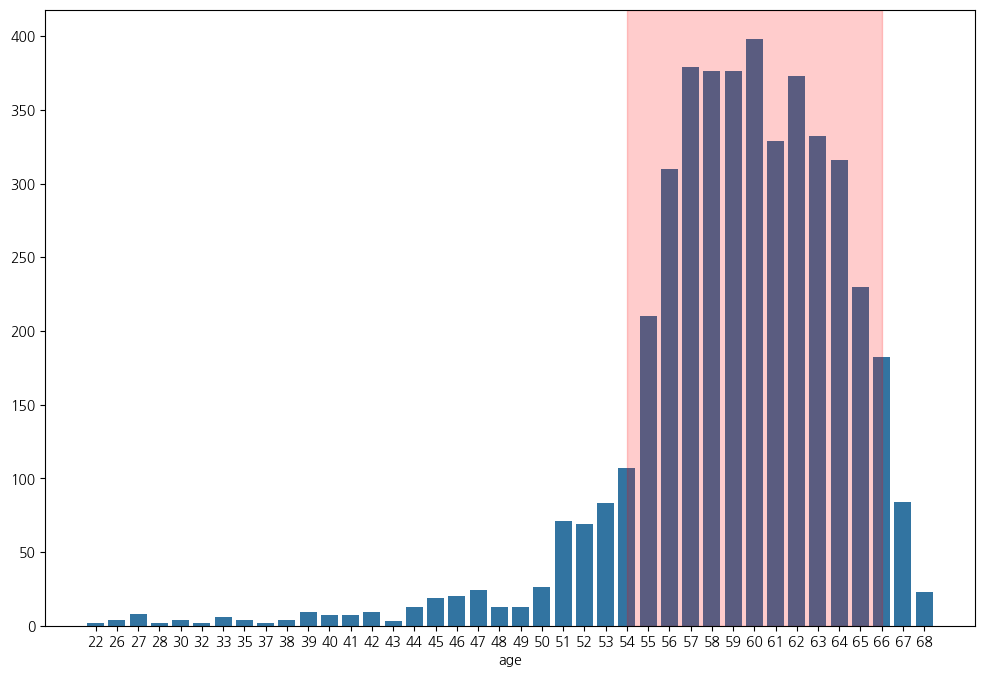

결측값 대체 전 job_type의 결측값의 수는  8171 개 입니다.
결측값 대체 후 job_type의 결측값의 수는  3731 개 입니다.


In [ ]:
# 연금 수령자의 나이 분포 시각화 및 결측값 일부 대체

# 음수로 되어있는 일자 관련 피쳐
minus_col = ['days_birth', 'days_employed','begin_month']

for i in minus_col:
  train[i] = -train[i]
  test[i] = -test[i]

# 나이 피쳐 생성
train['age'] = train['days_birth'] // 365
test['age'] = test['days_birth'] // 365

# 연금수령자 나이 분포 시각화
pension_age = train[train['income_type'] == 'Pensioner']['age'].value_counts().sort_index()
plt.figure(figsize=(12,8))
sns.barplot(x=pension_age.index, y=pension_age.values)
plt.axvspan(25,37,color='red',alpha=0.2)
plt.show()

# job_type의 결측값 개수 출력
print('결측값 대체 전 job_type의 결측값의 수는 ', len(train[train['job_type'] == 'nan']), '개 입니다.')

# 연금 수령자(Pensioner)의 job_type을 'No job' 으로 대체
train.loc[(train['job_type']=='nan')&(train['income_type']=='Pensioner'), 'job_type'] = 'No job'

test.loc[(test['job_type'] == 'nan') & (test['income_type'] == 'Pensioner'), 'job_type'] = 'No job'

# 결측치 대체 후 job_type의 결측값 개수 출력
print('결측값 대체 후 job_type의 결측값의 수는 ',len(train[train['job_type'] == 'nan']), '개 입니다.')

In [ ]:
# 나머지 결측값도 대체해야함
# 등장 빈도가 낮은 job_type은 배제 / job_type별로 income_totla 평균값과 차이가 가장 적은 걸로 대체

# 결측값 대체 전 갯수 확인
print('결측값 대체 전 job_type의 결측값의 수는', len(train[train['job_type'] == 'nan']), '개 입니다.')

# 빈도가 낮은 하위 3개 카테고리 제외하고 job_type 고유값 리스트에 담기
included_job_types = train['job_type'].value_counts()[:-3].index.tolist()
included_job_types.remove('nan')

결측값 대체 전 job_type의 결측값의 수는 3731 개 입니다.


In [ ]:
# 결측치 제외하고 각 job_type별 income_total 평균 도출
mean_values = train[train['job_type'].isin(included_job_types)].groupby('job_type')['income_total'].mean()

# job_type 결측값 대체
for idx, row in train[train['job_type']=='nan'].iterrows():
  # 평균 차이 계산
  differences = abs(mean_values - row['income_total'])

  # 차이가 가장 작은 job_type 선택
  closest_job_type = differences.idxmin()

  # job_type 결측값 대체
  train.at[idx, 'job_type'] = closest_job_type

# 대체 후 결측값 수 계산
print('결측값 대체 후 job_type의 결측값의 수는 ',len(train[train['job_type'] == 'nan']), '개 입니다.')

결측값 대체 후 job_type의 결측값의 수는  0 개 입니다.


In [ ]:
# test 데이터도 동일하게 결측값 대체
for idx, row in test[test['job_type'] == 'nan'].iterrows():
    differences = abs(mean_values - row['income_total'])

    closest_job_type = differences.idxmin()

    test.at[idx, 'job_type'] = closest_job_type

# 대체 후 test 데이터의 'job_type' 결측값 수를 확인합니다.
print('test 데이터의 결측값 대체 후 job_type의 결측값의 수는 ',len(test[test['job_type'] == 'nan']), '개 입니다.')

test 데이터의 결측값 대체 후 job_type의 결측값의 수는  0 개 입니다.


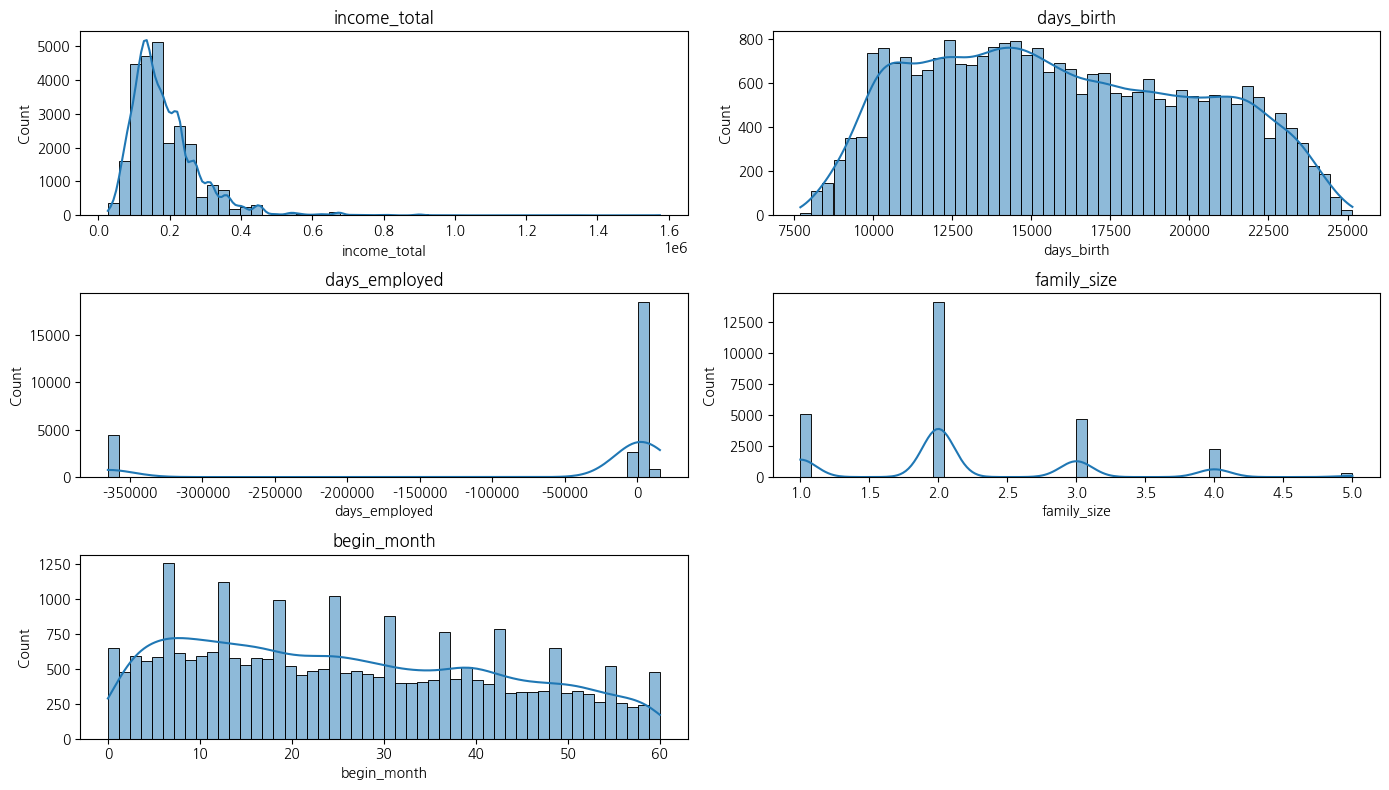

In [ ]:
# 극단치 재확인
# 연속형 변수 히스토그램으로 확인
sequential_columns = ['income_total','days_birth', 'days_employed', 'family_size','begin_month']

fig,ax = plt.subplots(3,2, figsize=(14,8))

for idx, col in enumerate(sequential_columns):
  r, c = divmod(idx,2)
  sns.histplot(train[col], bins=50, kde=True, ax=ax[r][c])
  ax[r][c].set_title(col)

# 빈 subplot은 제거
fig.delaxes(ax[2][1])

plt.tight_layout()
plt.show()

In [ ]:
# 이상치가 있는 days_employed 값을 가진 행의 job_type 확인 및 극단값 대체
outlier_employed = train['days_employed'].min()

train[train['days_employed'] == outlier_employed]['job_type'].value_counts()
outlier_df = train[train['days_employed'] == outlier_employed]['job_type']

# No job 이기 때문에 근무일수는 0으로 대체
train.loc[(train['days_employed']==outlier_employed), 'days_employed'] = 0
test.loc[(test['days_employed']==outlier_employed), 'days_employed'] = 0

In [ ]:
# 이진 범주형 컬럼 인코딩 하기
# 레이블 인코딩으로 변환
binary_col = ['gender', 'car', 'reality']

for column in binary_col:
    unique_values = train[column].unique()
    value_mapping = {value:idx for idx, value in enumerate(unique_values)}

    train[column] = train[column].replace(value_mapping) # {교체할 값 : 교체될 값} 을 딕셔너리로 바로 매핑 할 수 있음
    test[column] = test[column].replace(value_mapping)

train[binary_col].head()

,gender,car,reality
index,,,
0,0,0,0
1,0,0,1
2,1,1,1
3,0,0,1
4,0,1,1


In [ ]:
# 학력 순서에 따른 범주형 인코딩
edu_order = ['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 'Higher education', 'Academic degree']

# 학력 순서에 따른 인코딩 딕셔너리 생성
edu_mapping = {edu:idx for idx, edu in enumerate(edu_order)}

# 인코딩 수행
train['edu_type_encoded'] = train['edu_type'].replace(edu_mapping)
test['edu_type_encoded'] = test['edu_type'].replace(edu_mapping)

# 결과 확인
display(train[['edu_type', 'edu_type_encoded']].drop_duplicates().reset_index(drop = True))

,edu_type,edu_type_encoded
0,Higher education,3
1,Secondary / secondary special,1
2,Incomplete higher,2
3,Lower secondary,0
4,Academic degree,4


In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
# 나머지 이진 이상의 범주형 변수 -> 바이너리 인코딩을 통한 변환 처리
import category_encoders as ce

print(f"job_type 칼럼의 고유값의 개수는 {train['job_type'].nunique()}개 입니다.")


# 선택할 범주형 칼럼들
categorical_cols = train.select_dtypes(include='object').columns.tolist()

# BinaryEncoder 초기화
encoder = ce.BinaryEncoder(cols=categorical_cols)

# 학습 데이터에 대해 fit_transform을 사용하여 인코딩
binary_train = encoder.fit_transform(train[categorical_cols])

# 테스트 데이터에 대해 transform을 사용하여 인코딩
binary_test = encoder.fit_transform(test[categorical_cols])

# 인코딩된 데이터를 원래 데이터에 추가
train = pd.concat([train, binary_train], axis=1)
test = pd.concat([test, binary_test], axis=1)

# 원본 범주형 칼럼 삭제
train.drop(categorical_cols, axis=1, inplace=True)
test.drop(categorical_cols, axis=1, inplace=True)

# 예시 - job_type 칼럼에 대해 몇 개의 칼럼이 생성되었는지 확인
created_job_type_num = 0
for i in train.columns:
    if 'job_type' in i:
        created_job_type_num += 1
print(f"job_type 칼럼에 바이너리 인코딩을 적용한 결과 {created_job_type_num}개의 칼럼이 생성되었습니다.")

train.head()

job_type 칼럼의 고유값의 개수는 19개 입니다.
job_type 칼럼에 바이너리 인코딩을 적용한 결과 5개의 칼럼이 생성되었습니다.


,gender,car,reality,child_num,income_total,days_birth,days_employed,FLAG_MOBIL,work_phone,phone,...,family_type_1,family_type_2,house_type_0,house_type_1,house_type_2,job_type_0,job_type_1,job_type_2,job_type_3,job_type_4
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,202500.0,13899,4709,1,0,0,...,0,1,0,0,1,0,0,0,0,1
1,0,0,1,1,247500.0,11380,1540,1,0,0,...,1,0,0,1,0,0,0,0,1,0
2,1,1,1,0,450000.0,19087,4434,1,0,1,...,0,1,0,1,0,0,0,0,1,1
3,0,0,1,0,202500.0,15088,2092,1,0,1,...,0,1,0,1,0,0,0,1,0,0
4,0,1,1,0,157500.0,15037,2105,1,0,0,...,0,1,0,1,0,0,0,0,1,1


In [ ]:
train = train[['gender','car','reality','child_num','income_total','edu_type_encoded','days_birth','days_employed','work_phone',\
              'phone','email','family_size','begin_month','credit','age','income_type_0','income_type_1','income_type_2',\
               'family_type_0','family_type_1','family_type_2','house_type_0','house_type_1','house_type_2',\
               'job_type_0', 'job_type_1','job_type_2','job_type_3','job_type_4']]

In [ ]:
test = test[['gender','car','reality','child_num','income_total','edu_type_encoded','days_birth','days_employed','work_phone',\
              'phone','email','family_size','begin_month','age','income_type_0','income_type_1','income_type_2',\
               'family_type_0','family_type_1','family_type_2','house_type_0','house_type_1','house_type_2',\
               'job_type_0', 'job_type_1','job_type_2','job_type_3','job_type_4']]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26457 entries, 0 to 26456
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            26457 non-null  int64  
 1   car               26457 non-null  int64  
 2   reality           26457 non-null  int64  
 3   child_num         26457 non-null  int64  
 4   income_total      26457 non-null  float64
 5   edu_type_encoded  26457 non-null  int64  
 6   days_birth        26457 non-null  int64  
 7   days_employed     26457 non-null  int64  
 8   work_phone        26457 non-null  int64  
 9   phone             26457 non-null  int64  
 10  email             26457 non-null  int64  
 11  family_size       26457 non-null  float64
 12  begin_month       26457 non-null  float64
 13  credit            26457 non-null  float64
 14  age               26457 non-null  int64  
 15  income_type_0     26457 non-null  int64  
 16  income_type_1     26457 non-null  int64  
 17

- 범주형 변수들은 모두 인코딩 완료

# 4. Feature Engineering & Modeling
- 모델링을 통한 성능 확인 및 개선

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

# 데이터 나누기
copy_train = train.copy()
train_data, valid_data = train_test_split(copy_train, stratify=copy_train['credit'], test_size=0.2, random_state=42)

x_train = train_data.drop('credit', axis=1)
y_train = train_data['credit']
x_valid = valid_data.drop('credit', axis=1)
y_valid = valid_data['credit']

# K-Fold 설정
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

log_losses = []

for train_idx, valid_idx in skf.split(x_train, y_train):
    x_train_fold, x_valid_fold = x_train.iloc[train_idx], x_train.iloc[valid_idx]
    y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    model = RandomForestClassifier(n_estimators=50, random_state=42)
    model.fit(x_train_fold, y_train_fold)

    pred_probs = model.predict_proba(x_valid_fold)
    log_losses.append(log_loss(y_valid_fold, pred_probs))

average_log_loss = sum(log_losses) / len(log_losses)
print(f"평균 Log Loss의 값 : {average_log_loss}")

평균 Log Loss의 값 : 1.1830073558533702


- 베이스라인 기준 점수 : 1.1830073558533702
- 기준점수와 비교하여 피처엔지니어링 및 모델 하이퍼파라미터 개선 진행

In [ ]:
# 나이 구간화를 적용하여 검증 결과 비교

copy_train = train.copy()
train_data, valid_data = train_test_split(copy_train, stratify=copy_train['credit'], test_size=0.2, random_state=42)

x_train = train_data.drop('credit', axis=1)
y_train = train_data['credit']
x_valid = valid_data.drop('credit', axis=1)
y_valid = valid_data['credit']

min_age = x_train['age'].min()
max_age = x_train['age'].max()
bins = list(range(min_age-10, max_age+10, 10))
labels = range(len(bins)-1)

x_train['age_group'] = pd.cut(x_train['age'], bins=bins, labels=labels, right=False)
x_valid['age_group'] = pd.cut(x_valid['age'], bins=bins, labels=labels, right=False)

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

log_losses = []

for train_idx, valid_idx in skf.split(x_train, y_train):
  x_train_fold, x_valid_fold = x_train.iloc[train_idx], x_train.iloc[valid_idx]
  y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

  model = RandomForestClassifier(n_estimators=50, random_state=42)
  model.fit(x_train_fold, y_train_fold)

  pred_probs = model.predict_proba(x_valid_fold)
  log_losses.append(log_loss(y_valid_fold, pred_probs))

average_log_loss = sum(log_losses) / len(log_losses)
print(f"평균 Log Loss의 값 : {average_log_loss}")

평균 Log Loss의 값 : 1.25581696423512


- age_group으로 구간을 나눈 피처를 추가하는 것이 오히려 성능이 안좋아짐

In [ ]:
from tqdm import tqdm

def get_log_loss(df):
  copy_train = df.copy()

  train_data, valid_data = train_test_split(copy_train, stratify=copy_train['credit'], test_size=0.2, random_state=42)

  x_train = train_data.drop('credit', axis=1)
  y_train = train_data['credit']

  skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
  log_losses = []

  for train_idx, valid_idx in skf.split(x_train, y_train):
    x_train_fold, x_valid_fold = x_train.iloc[train_idx], x_train.iloc[valid_idx]
    y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    model = RandomForestClassifier(n_estimators=50, random_state=42)
    model.fit(x_train_fold, y_train_fold)

    pred_probs = model.predict_proba(x_valid_fold)
    log_losses.append(log_loss(y_valid_fold, pred_probs))

  average_log_loss = sum(log_losses) / len(log_losses)
  return average_log_loss

# 각 피쳐 추가 및 검증 점수 확인
# 순서대로 [고용전 일수, 근속연수, 근속일별 소득, 가족수 대비 소득]

fe_features = [
    ('before_employed', lambda df: df['days_birth']-df['days_employed']),
    ('employed_year', lambda df: df['days_employed']//365),
    ('income_by_employed_days', lambda df: df.apply(lambda row: 0 if row['days_employed'] == 0\
                                                    else row['income_total']/row['days_employed'], axis=1)),
    ('income_by_family', lambda df: df['income_total']/df['family_size'])
]

for feature_name, feature_func in tqdm(fe_features):
  train[feature_name] = feature_func(train)
  log_loss_score = get_log_loss(train)
  print(f"{feature_name} 추가 후의 로그손실 점수: {log_loss_score}")

# 하나의 칼럼을 추가했을 때 그 결과를 확인하기 위해 drop() 메서드 사용
# drop() 메서드를 사용하지 않을 경우 네 가지의 피처를 하나씩 순차적으로 데이터프레임에 추가
  train = train.drop(feature_name, axis = 1)

 25%|██▌       | 1/4 [00:07<00:23,  7.89s/it]

before_employed 추가 후의 로그손실 점수: 1.2420843002811643


 50%|█████     | 2/4 [00:17<00:18,  9.13s/it]

employed_year 추가 후의 로그손실 점수: 1.2161768094921563


 75%|███████▌  | 3/4 [00:27<00:09,  9.19s/it]

income_by_employed_days 추가 후의 로그손실 점수: 1.198055750467868


100%|██████████| 4/4 [00:34<00:00,  8.61s/it]

income_by_family 추가 후의 로그손실 점수: 1.258509517762622


In [ ]:
# 성별 기반 소득 보정 및 KMeans 클러스터링을 이용한 특성 공학 및 모델 평가
from sklearn.cluster import KMeans

gender_income_mean = train.groupby('gender')['income_total'].mean()
weight = gender_income_mean[1] / gender_income_mean[0]  # 1: 남성, 0: 여성

cluster_gender_features = [
    ('adjusted_income',
     lambda df: df.apply(
         lambda row: row['income_total'] * weight
         if row['gender'] == 0 else row['income_total'], axis=1
     )),
    ('cluster',
     lambda df: KMeans(n_clusters=100, n_init=10, random_state=42)
     .fit(df.drop(['credit'], axis=1))
     .predict(df.drop(['credit'], axis=1)))
]

for feature_name, feature_func in tqdm(cluster_gender_features):
    train[feature_name] = feature_func(train)
    log_loss_score = get_log_loss(train)
    print(f"{feature_name} 추가 후의 로그손실 점수: {log_loss_score}")

    train = train.drop(feature_name, axis = 1)

 50%|█████     | 1/2 [00:07<00:07,  7.21s/it]

adjusted_income 추가 후의 로그손실 점수: 1.2079458578170394


100%|██████████| 2/2 [00:21<00:00, 10.75s/it]

cluster 추가 후의 로그손실 점수: 1.2104382958714186


- 성능이 개선되지 않은 피쳐
: before_employed / employed_year / income_by_employed_days / income_by_family / adjusted_income / cluster

# 5. 피쳐 선택 및 모델 고도화
- 전체 데이터에서 모델이 학습할 피쳐를 최종적으로 선택
- 앙상블 기법으로 모델 고도화

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26457 entries, 0 to 26456
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            26457 non-null  int64  
 1   car               26457 non-null  int64  
 2   reality           26457 non-null  int64  
 3   child_num         26457 non-null  int64  
 4   income_total      26457 non-null  float64
 5   edu_type_encoded  26457 non-null  int64  
 6   days_birth        26457 non-null  int64  
 7   days_employed     26457 non-null  int64  
 8   work_phone        26457 non-null  int64  
 9   phone             26457 non-null  int64  
 10  email             26457 non-null  int64  
 11  family_size       26457 non-null  float64
 12  begin_month       26457 non-null  float64
 13  credit            26457 non-null  float64
 14  age               26457 non-null  int64  
 15  income_type_0     26457 non-null  int64  
 16  income_type_1     26457 non-null  int64  
 17

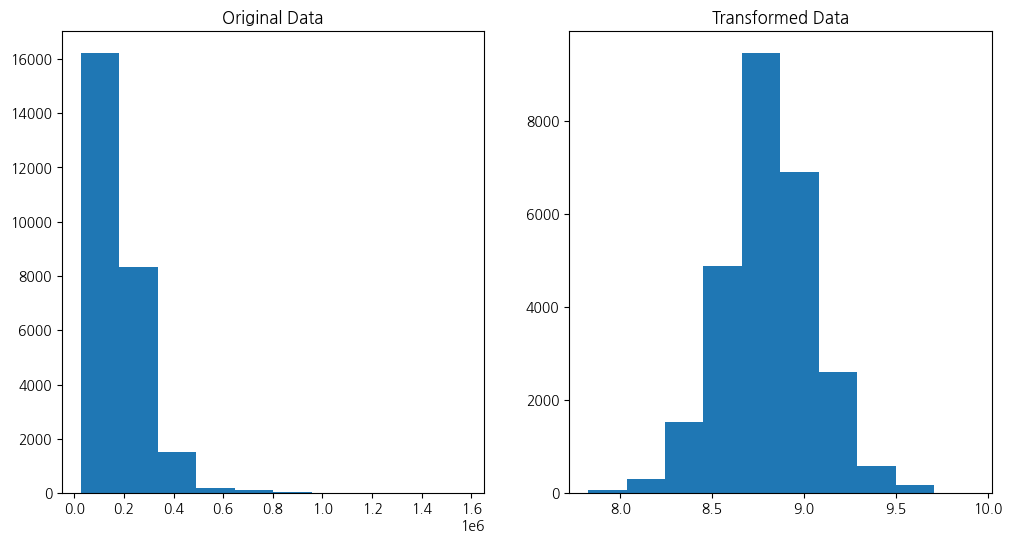

,gender,car,reality,child_num,income_total,edu_type_encoded,days_birth,days_employed,work_phone,phone,...,family_type_1,family_type_2,house_type_0,house_type_1,house_type_2,job_type_0,job_type_1,job_type_2,job_type_3,job_type_4
0,-0.703562,-0.782463,-1.437626,-0.573599,0.419704,1.584991,-0.490075,1.059227,-0.538417,-0.645705,...,-0.400811,0.519280,-0.16833,-4.300777,3.092878,-0.158704,-0.713129,-0.846025,-1.401441,1.370726
1,-0.703562,-0.782463,0.695591,0.764529,0.830609,-0.636213,-1.089621,-0.277849,-0.538417,-0.645705,...,2.494943,-1.925744,-0.16833,0.232516,-0.323323,-0.158704,-0.713129,-0.846025,0.713551,-0.729540
2,1.421339,1.278015,0.695591,-0.573599,2.028457,1.584991,0.744719,0.943198,-0.538417,1.548696,...,-0.400811,0.519280,-0.16833,0.232516,-0.323323,-0.158704,-0.713129,-0.846025,0.713551,1.370726
3,-0.703562,-0.782463,0.695591,-0.573599,0.419704,-0.636213,-0.207081,-0.044947,-0.538417,1.548696,...,-0.400811,0.519280,-0.16833,0.232516,-0.323323,-0.158704,-0.713129,1.181998,-1.401441,-0.729540
4,-0.703562,1.278015,0.695591,-0.573599,-0.101283,1.584991,-0.219220,-0.039462,-0.538417,-0.645705,...,-0.400811,0.519280,-0.16833,0.232516,-0.323323,-0.158704,-0.713129,-0.846025,0.713551,1.370726


In [ ]:
# 데이터 스케일링
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox

# 정규분포 변환
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].hist(train['income_total'])
ax[0].set_title('Original Data')

train['income_total'], optimal_lambda = boxcox(train['income_total'])
test['income_total'] = boxcox(test['income_total'], lmbda = optimal_lambda)

# boxcox로 변환 후 확인
ax[1].hist(train['income_total'])
ax[1].set_title('Transformed Data')
plt.show()

# X,y 분리
x_train = train.drop('credit', axis=1)
y_train = train['credit']

columns_list = x_train.columns

# 스케일링
scaler = StandardScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = columns_list)
x_test_scaled = pd.DataFrame(scaler.fit_transform(test), columns = columns_list)

x_train_scaled.head()

([<matplotlib.patches.Wedge at 0x7a339194ffd0>,
 [Text(-0.27650215010685664, -1.0646814363866244, 'credit 2'),
  Text(0.6539837843810778, 0.8844801918452465, 'credit 1'),
  Text(-0.5177599832527523, 0.9705280004936023, 'credit 0')],
 [Text(-0.15081935460373996, -0.5807353289381586, '64.1%'),
  Text(0.35671842784422425, 0.48244374100649806, '23.7%'),
  Text(-0.28241453631968305, 0.5293789093601466, '12.2%')])

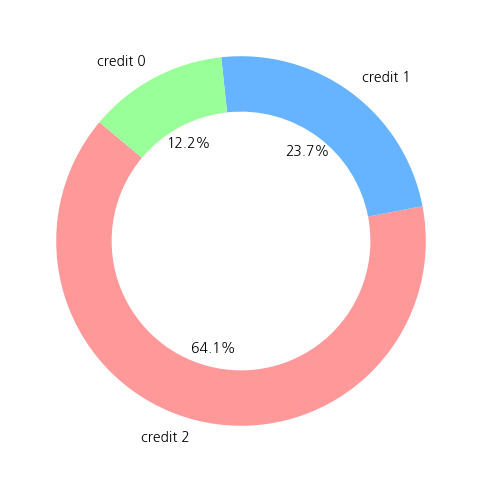

In [ ]:
# 클래스 불균형이 심함 -> 오버 샘플링 활용
credit_counts = train['credit'].value_counts()
#credit_counts.plot(kind='bar')

# 데이터 준비
labels = ['credit 2', 'credit 1', 'credit 0']
colors = ['#ff9999','#66b3ff','#99ff99']

# 도넛 차트 그리기
plt.figure(figsize=(8, 6))
plt.pie(credit_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))

In [ ]:
# SMOTE 및 ADASYN 기법
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

# 데이터 분리
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train_scaled, y_train, test_size=0.2, random_state=42)

# SMOTE 를 활용한 오버샘플링
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_split, y_train_split)

# ADASYN을 활용한 오버샘플링
adasyn = ADASYN(random_state=42)
x_train_adasyn, y_train_adasyn = adasyn.fit_resample(x_train_split, y_train_split)

# RandomForest
smote_rf = RandomForestClassifier(random_state=42)
adasyn_rf = RandomForestClassifier(random_state=42)

# SMOTE
smote_rf.fit(x_train_smote, y_train_smote)
smote_proba = smote_rf.predict_proba(x_valid_split)
smote_logloss = log_loss(y_valid_split, smote_proba)

# ADASYN
adasyn_rf.fit(x_train_adasyn, y_train_adasyn)
adasyn_proba = adasyn_rf.predict_proba(x_valid_split)
adasyn_logloss = log_loss(y_valid_split, adasyn_proba)

print("SMOTE Log Loss 점수는 : ", smote_logloss)
print("ADASYN Log Loss 점수는 : ", adasyn_logloss)


SMOTE Log Loss 점수는 :  1.1910224609023283
ADASYN Log Loss 점수는 :  1.1461111359549392


In [ ]:
# ADASYN 을 활용한 데이터 오버 샘플링
adasyn = ADASYN(random_state=42)
x_train_over, y_train_over = adasyn.fit_resample(x_train_scaled, y_train)

y_train_over.value_counts()

,count
credit,
1.0,17425
0.0,17345
2.0,16968


In [ ]:
# 랜덤포레스트를 사용한 RFECV 피처 선택 및 중요도 시각화
# 후진소거법을 이용하여 피쳐 중요도 확인
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, log_loss
import time

start = time.time()

# 랜덤포레스트 분류기 초기화
rf = RandomForestClassifier(n_estimators = 50, random_state=42)

# 사용자 정의 스코어 함수 생성
neg_log_loss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# RFECV 객체 생성
selector = RFECV(estimator=rf, step=1, cv=5, scoring=neg_log_loss, min_features_to_select=10)
selector = selector.fit(x_train_over, y_train_over)

# 선택된 피쳐들의 실제 이름
selected_feature_names = x_train_over.columns[selector.support_]
print("피처의 수:", selector.n_features_)
print("선택된 피처의 이름:", selected_feature_names)

# 피쳐 중요도 가져오기
feature_importances = selector.estimator_.feature_importances_

# 피처 중요도와 선택된 피처 이름을 함께 정렬
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_names = selected_feature_names[sorted_idx]

피처의 수: 12
선택된 피처의 이름: Index(['gender', 'car', 'reality', 'income_total', 'edu_type_encoded',
       'days_birth', 'days_employed', 'phone', 'family_size', 'begin_month',
       'age', 'job_type_2'],
      dtype='object')


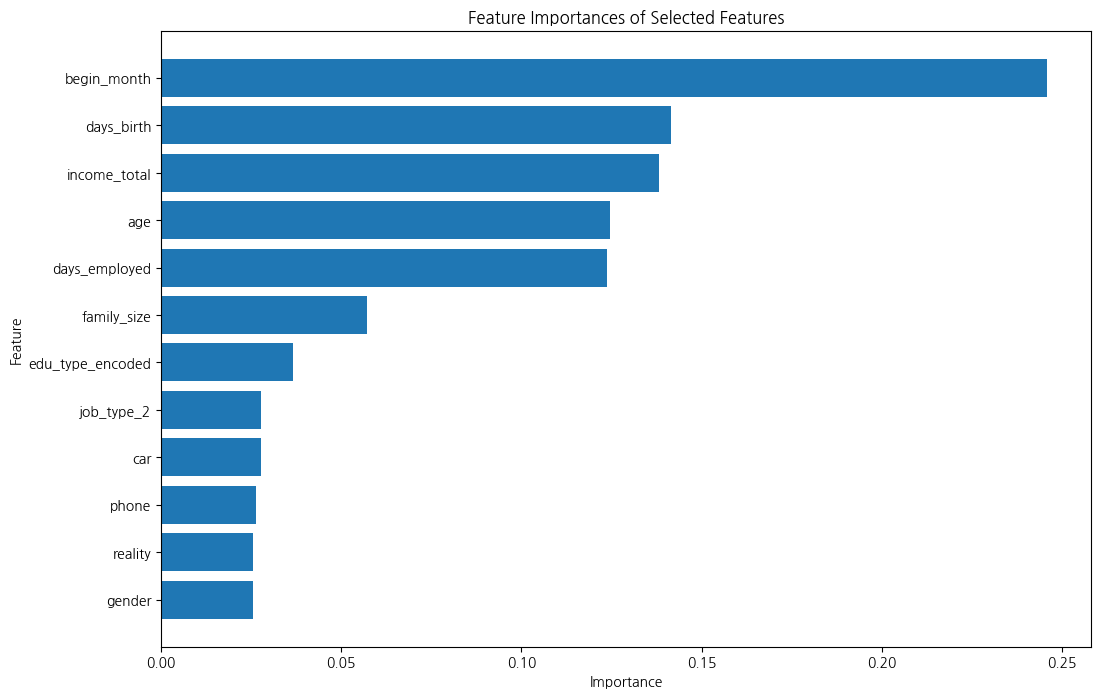

In [ ]:
plt.figure(figsize=(12,8))
plt.barh(range(selector.n_features_), feature_importances[sorted_idx], align='center')
plt.yticks(range(selector.n_features_), sorted_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Selected Features')
plt.gca().invert_yaxis()  # 높은 중                                                                                                                                                                                                                                                                                              요도가 위에 오도록 y축을 뒤집음
plt.show()

100%|██████████| 12/12 [03:44<00:00, 18.68s/it]


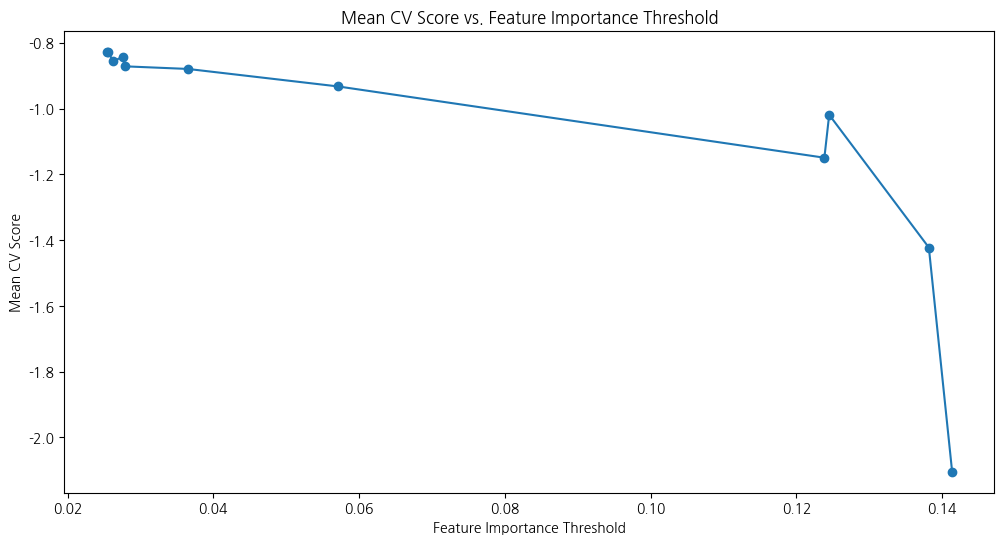

최적의 임계값: 0.025372797921420557
해당 임계값에서의 검증 점수: -0.826877801637513
선택된 피처의 개수: 11
선택된 피처: Index(['car', 'reality', 'income_total', 'edu_type_encoded', 'days_birth',
       'days_employed', 'phone', 'family_size', 'begin_month', 'age',
       'job_type_2'],
      dtype='object')
소요된 시간(초): , 224.48760676383972


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.ensemble import RandomForestClassifier  # RandomForestClassifier 임포트

start = time.time()

# 중요도 임계값 설정 - 임계값이 오름차순으로 정렬됩니다.
thresholds = np.sort(feature_importances)

# 각 임계값에 따른 검증 점수 저장
scores = []

# 최적의 검증 점수와 해당 시점의 임계값 저장
best_score = float('-inf')
best_threshold = None
best_feature_count = 0

for threshold in tqdm(thresholds):
    # 임계값보다 중요도가 큰 피처 선택
    select_feature = selected_feature_names[feature_importances > threshold]

    # 선택된 피처가 없는 경우 검증 점수 계산 스킵
    if len(select_feature) == 0:
        continue

    # RandomForestClassifier 모델을 매 반복마다 새로 생성
    rf = RandomForestClassifier(n_estimators=50)  # 모델 정의

    # 데이터에서 해당 피처만 추출
    x_train_selected = x_train_over[select_feature]

    # 교차 검증을 통한 점수 계산
    score = cross_val_score(rf, x_train_selected, y_train_over, cv=3, scoring='neg_log_loss').mean()
    scores.append(score)

    # 최적의 검증 점수 업데이트
    if score > best_score:
        best_score = score
        best_threshold = threshold
        best_feature_count = len(select_feature)

# 검증 점수 시각화
plt.figure(figsize=(12,6))
plt.plot(thresholds[:len(scores)], scores, marker='o')
plt.xlabel("Feature Importance Threshold")
plt.ylabel("Mean CV Score")
plt.title("Mean CV Score vs. Feature Importance Threshold")
plt.show()

print(f"최적의 임계값: {best_threshold}")
print(f"해당 임계값에서의 검증 점수: {best_score}")
print(f"선택된 피처의 개수: {best_feature_count}")
print(f"선택된 피처: {selected_feature_names[feature_importances > best_threshold]}")

print(f'소요된 시간(초): , {time.time() - start}')

In [ ]:
#선택된 피처를 활용한 RandomForest 및 XGBosst 기반 보팅 앙상블
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

start = time.time()

# RFECV를 통해 얻은 피처 중요도에 따라 최적의 임계값을 초과하는 피처들만 선택
final_use_cols = selected_feature_names[feature_importances > best_threshold]
x_train_final = x_train_over[final_use_cols]
y_final = y_train_over

# 1번 모델
rf = RandomForestClassifier(n_estimators = 500, random_state=42)

# 2번 모델
xgb = XGBClassifier(n_estimators = 500, random_state=42)

# Soft Voting 기반의 앙상블 모델 생성
soft_voting_clf = VotingClassifier(
    estimators=[('randomforest', rf), ('xgboost', xgb)],
    voting='soft'
)

# 교차 검증을 사용하여 Soft Voting 앙상블 모델의 검증 점수 계산
soft_voting_scores = cross_val_score(soft_voting_clf, x_train_final, y_final, cv=5, scoring='neg_log_loss')
print("Soft Voting Cross Val Score:", soft_voting_scores.mean())
print(f'소요된 시간(초): , {time.time() - start}')

Soft Voting Cross Val Score: -0.6330034383266214
소요된 시간(초): , 448.2417929172516


In [ ]:
# soft voting 으로 앙상블한 모델을 최종 test 데이터 셋에 적용
x_test_final = x_test_scaled[final_use_cols]

# 모델 학습
soft_voting_clf.fit(x_train_final, y_final)

# x_test_final 데이터 credit 예측 확률 확인
soft_voting_predictions = soft_voting_clf.predict_proba(x_test_final)

In [ ]:
prediction_test_url = '/content/dataset/open/sample_submission.csv'
prediction_test = pd.read_csv(prediction_test_url, index_col=0)
prediction_test.head()

,0,1,2
index,,,
26457,0,0,0
26458,0,0,0
26459,0,0,0
26460,0,0,0
26461,0,0,0


In [ ]:
# 예측된 결과를 prediction_test 데이터 프레임에 확률을 저장
prediction_test.iloc[:,:] = soft_voting_predictions
prediction_test.head()

,0,1,2
index,,,
26457,0.405173,0.427668,0.167159
26458,0.626147,0.297335,0.076518
26459,0.381198,0.343826,0.274976
26460,0.652606,0.258375,0.089020
26461,0.235651,0.594051,0.170298


In [ ]:
# 파일 저장
#prediction_test.to_csv('prediction_test_final', index=False)

---

In [ ]:
prediction_test.to_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/1. 신용카드 연체 예측/credit_card/data/prediction_test.csv')